# Training Data




## This notebook assumes you have the DC2 data downloaded  

You will have to change directorty paths

In [1]:
# In case you need to point to pre-existing scarlet install
import sys
sys.path.insert(0, '/home/yse2/deepdisc/src')
sys.path.insert(0, '/home/yse2/detectron2')
import deepdisc
import detectron2
print(deepdisc.__file__)
print(detectron2.__file__)

/home/yse2/deepdisc/src/deepdisc/__init__.py
/home/yse2/detectron2/detectron2/__init__.py


In [2]:
# Standard imports
import sys, os
import numpy as np
import time
import glob

import scarlet
import sep
import cv2


import astropy.io.fits as fits
from astropy.wcs import WCS
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.coordinates import SkyCoord

from scarlet.display import AsinhMapping
from astropy.nddata import Cutout2D

# Astrodet imports
import deepdisc.preprocessing.detection as detection
import deepdisc.preprocessing.process as process

from deepdisc.astrodet.hsc import get_tract_patch_from_coord, get_hsc_data

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib
import matplotlib.pyplot as plt

# use a better colormap and don't interpolate the pixels
#matplotlib.rc('image', cmap='gray', interpolation='none', origin='lower')
from skimage.util.shape import view_as_blocks
from matplotlib import colors

import pandas as pd
import math
from astropy.table import Table

In [3]:
# Print the versions to test the imports and so we know what works
print(scarlet.__version__)
print(np.__version__)
print(sep.__version__)

1.0.1+g11d1363
1.23.4
1.2.1


In [4]:
from deepdisc.preprocessing.get_data import get_cutout
filters = ['u','g','r','i','z','y']
#dirpath = '/home/g4merz/DC2/coadd-t3828-t3829/deepCoadd-results/'
dirpath = '/home/shared/hsc/DC2/raw_data/dr6/'
nb=8 #The number of cutouts per side of an image.  4k CCDs are too large to train with, so we reduce the size
sp=22 #The "subpatch", i.e. which of the nb x nb cutouts to use 
tract = 3828
patch = "1_1"

### Using an input catalog

The cells below assume you have an input catalog `all_tracts_cat.csv` corresponding to the tracts and patches you've downloaded.  We can run the code without one, but it is necessary for truth-matching any quantities

In [5]:
import importlib
importlib.reload(deepdisc.preprocessing.get_data)
import deepdisc.preprocessing.get_data 
from deepdisc.preprocessing.get_data import get_cutout
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.stats import gaussian_fwhm_to_sigma

In [ ]:
dall=pd.read_csv('/home/shared/hsc/DC2/raw_data/all_tracts_truth_cat.csv')
#dall=pd.read_csv('/home/g4merz/DC2/nersc_data/data/tracts_data/all_tracts_cat.csv')
dall
# ra_all = dall['ra'][:].values
# dec_all = dall['dec'][:].values
# allcatalog = SkyCoord(ra=ra_all*u.degree, dec=dec_all*u.degree)

In [11]:
dall['tract'].unique()

array([3828, 3829, 3640, 3639, 4643, 4642, 3079, 3078])

In [13]:
import re
match = re.search("./lsst_data/truth/(\d+)/(\d+,\d+)/full_c\d+\.npy", "./lsst_data/truth/3828/1,1/full_c215.npy")
tract = match.group(1)
patch = match.group(2)
print("Tract:", tract)
print("Patch:", patch)

Tract: 3828
Patch: 1,1


In [7]:
# dpatch=pd.read_csv('/home/shared/hsc/DC2/raw_data/3828_1,2_truthcat.csv')
#dall=pd.read_csv('/home/g4merz/DC2/nersc_data/data/tracts_data/all_tracts_cat.csv')
# dpatch = pd.read_csv('/home/shared/hsc/roman_lsst/3828_1,2_full_gal_star_cat.csv')
all_patch = pd.read_csv('/home/shared/hsc/roman_lsst/3828_all_gal_star_cat.csv')
dpatch = all_patch[all_patch['patch'] == patch.replace('_', ',')]

ra_patch = dpatch['ra'][:].values
dec_patch = dpatch['dec'][:].values
patchcatalog = SkyCoord(ra=ra_patch*u.degree, dec=dec_patch*u.degree)

In [8]:
print("# of Stars: ", len(dpatch[dpatch['truth_type'] == 2]), "\n# of Galaxies: ", len(dpatch[dpatch['truth_type'] == 1]))

# of Stars:  505 
# of Galaxies:  22905


In [8]:
#fitscat = Table.read('/home/shared/hsc/DC2/raw_data/btk_3828_1,2_truthcat.fits', format='fits')
#dpatch_btk = fitscat.to_pandas()

#ra_patch_btk = dpatch_btk['ra'][:].values
#dec_patch_btk = dpatch_btk['dec'][:].values
#patchcatalog_btk = SkyCoord(ra=ra_patch_btk*u.degree, dec=dec_patch_btk*u.degree)

In [9]:
def get_cutout_cat(dirpath,dcat,skycoords, id_col, tract,patch,sp,nblocks=4,filters=['u','g','r','i','z','y']):
    '''
        WARNING!!!!!
        It is not efficient to have the full catalog (defined here as dall) as input to a function when doing multiprocesing.  
        Keep it in the top level process
    '''
    # the below should work properly
    cutout,datsm, psf = get_cutout(dirpath,tract=tract,patch=patch,sp=sp,nblocks=nblocks,filters=filters,plot=False, get_psf=True)
    print(cutout.wcs.to_header_string())
    xs,ys = cutout.wcs.world_to_pixel(skycoords)

    inds = np.where((xs>=0) & (xs<cutout.shape[1]-1) & (ys>=0) & (ys<cutout.shape[0]-1))[0]
    
 
    dcut = dcat.iloc[inds]

    dcut['new_x'] = xs[inds]
    dcut['new_y'] = ys[inds]
    
#     dcut = dcut[dcut['mag_i']<25.3] # REMOVE THIS CUT

    
#     column_to_move = dcut.pop(id_col)

#     # insert column with insert(location, column_name, column_value)
#     dcut.insert(0, id_col, column_to_move)
#     dcut.sort_values(by=id_col)
    
    return datsm, dcut#, psf

In [10]:
# doable with combined catalog just pass in both galaxy_id and id to move to the beginning of df
datsm,dcut = get_cutout_cat(dirpath, dpatch, patchcatalog, 'galaxy_id', '3828','1,1',21,nblocks=16)
# datsmn, dcutn = get_cutout_cat(dirpath, dpatch, patchcatalog, 'galaxy_id', '2877','0,3', sp, nblocks=nb)
#datsm2,dcut2,psf2 = get_cutout_cat(dirpath, dpatch_btk, patchcatalog_btk, 'galaxy_id', '3828','1,2',29,nblocks=16)

WCSAXES =                    2 / Number of coordinate axes                      CRPIX1  =               8790.0 / Pixel coordinate of reference point            CRPIX2  =               9838.0 / Pixel coordinate of reference point            PC1_1   = -5.5555555555586E-05 / Coordinate transformation matrix element       PC2_2   =  5.5555555555586E-05 / Coordinate transformation matrix element       CDELT1  =                  1.0 / [deg] Coordinate increment at reference point  CDELT2  =                  1.0 / [deg] Coordinate increment at reference point  CUNIT1  = 'deg'                / Units of coordinate increment and value        CUNIT2  = 'deg'                / Units of coordinate increment and value        CTYPE1  = 'RA---TAN'           / Right ascension, gnomonic projection           CTYPE2  = 'DEC--TAN'           / Declination, gnomonic projection               CRVAL1  =      56.649746192893 / [deg] Coordinate value at reference point      CRVAL2  =     -36.446280991736 / [deg] C

/tmp/ipykernel_2958155/2818201685.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_x'] = xs[inds]
/tmp/ipykernel_2958155/2818201685.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_y'] = ys[inds]


In [11]:
dcut.columns

Index(['Unnamed: 0', 'A_v', 'R_v', 'bulge_to_total_ratio_i', 'convergence',
       'dec', 'ellipticity_1_bulge_true', 'ellipticity_1_disk_true',
       'ellipticity_1_true', 'ellipticity_2_bulge_true',
       'ellipticity_2_disk_true', 'ellipticity_2_true', 'flux_g', 'flux_i',
       'flux_r', 'flux_u', 'flux_y', 'flux_z', 'galaxy_id', 'id', 'id_string',
       'mag_g', 'mag_i', 'mag_r', 'mag_true_g', 'mag_true_i', 'mag_true_r',
       'mag_true_u', 'mag_true_y', 'mag_true_z', 'mag_u', 'mag_y', 'mag_z',
       'patch', 'position_angle_true', 'position_angle_true_dc2', 'ra',
       'redshift', 'shear_1', 'shear_2', 'size_bulge_true', 'size_disk_true',
       'size_minor_bulge_true', 'size_minor_disk_true', 'size_minor_true',
       'size_true', 'truth_type', 'new_x', 'new_y'],
      dtype='object')

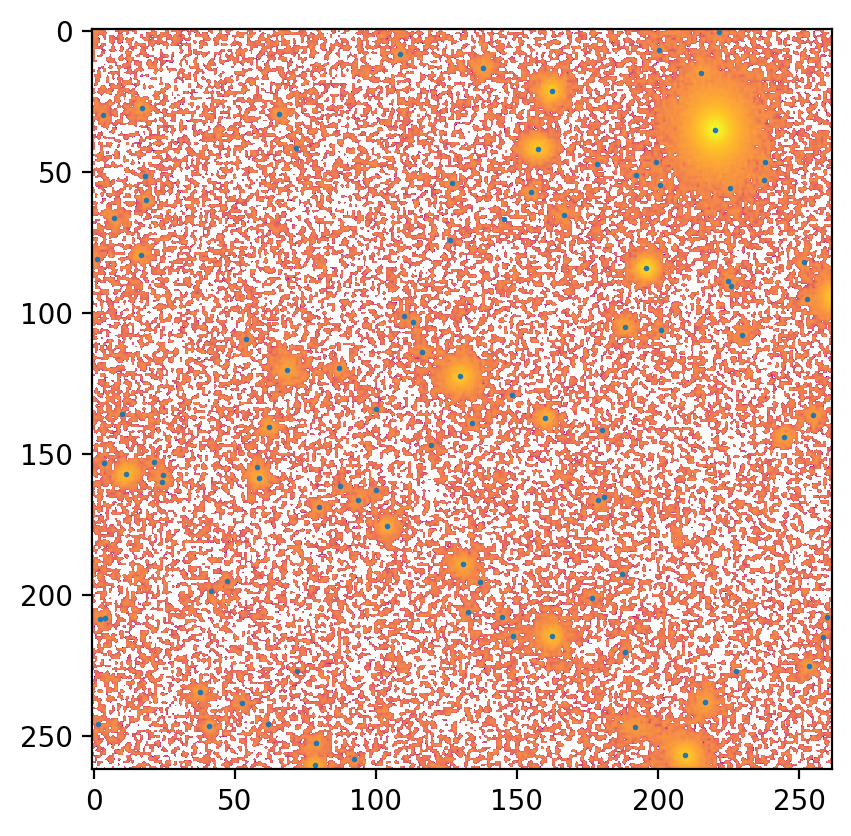

In [12]:
# plotting the i filter and corresponding data
plt.imshow(datsm[3],norm=colors.LogNorm(), cmap='plasma')
# plt.axis('off')
plt.scatter(dcut.new_x.values,dcut.new_y.values,s=1)

### Using Overlapping LSST Data pulled from NERSC

/tmp/ipykernel_594064/2625421440.py:16: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  truth_cat = pd.read_json(truth_cat[0])


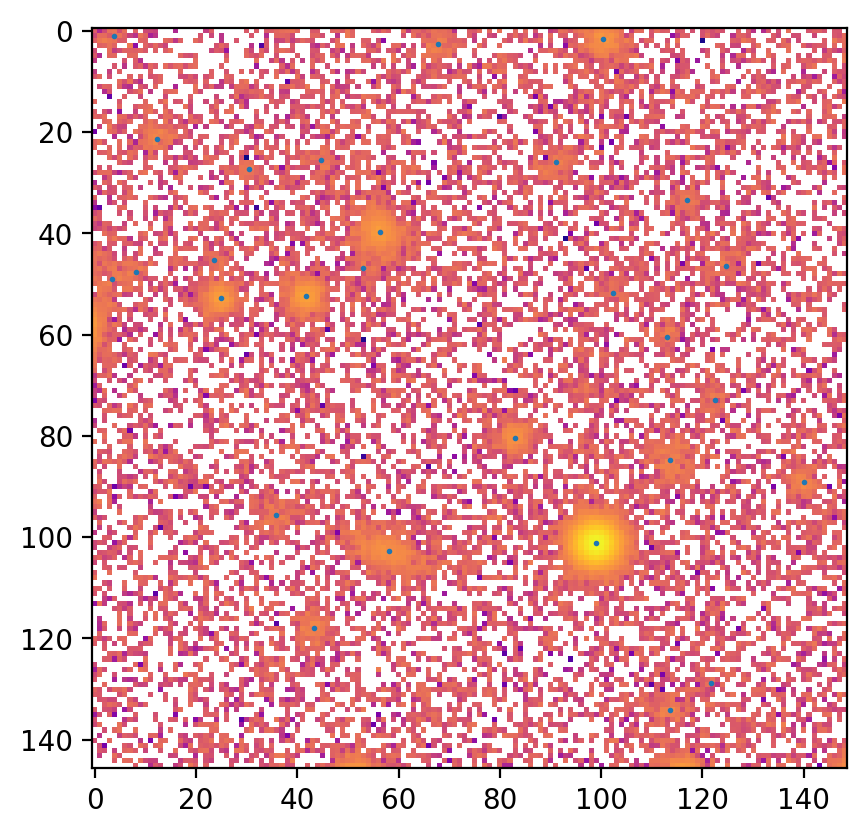

In [5]:
# plotting the r filter and corresponding data
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
with open('lsst_data/annotations/dc2_50.93_-42.0.json', 'r') as f:
    data = json.load(f)
d1 = data[2]
img = np.load(d1['file_name'])[2, :, :]
imgid = d1['image_id']
truth_cat = None
with open(f"lsst_data/truth/{d1['subpatch']}/{d1['subpatch']}_info.json", 'r') as f:
    all_truth_info = json.load(f)
    truth_cat = [truth_info['obj_catalog'] for truth_info in all_truth_info if truth_info['image_id'] == imgid]
truth_cat = pd.read_json(truth_cat[0])
plt.imshow(img,norm=colors.LogNorm(), cmap='plasma')
# plt.axis('off')
plt.scatter(truth_cat.new_x.values,truth_cat.new_y.values,s=1)

## Create annotations for each detected object based on the ellipticity and size(hlr)

In [13]:
L0 = 3.0128e28

def e1e2_to_ephi(e1,e2):
    
    pa = np.arctan(e2/e1)
    
    return pa

def dcut_reformat(cat, only_bttri=False):
    
    for band in ['u', 'g', 'r', 'i', 'z', 'y']:
        cat[f'{band}_ab'] = cat[f'mag_true_{band}']
    
    # only bulge to total ratio i-band from the cosmoDC2 GCR Catalog
    if only_bttri:
        total_flux = L0 * 10**(-0.4*cat[f'mag_true_i'])
        bulge_to_total_ratio = cat[f'bulge_to_total_ratio_i']

        cat[f'fluxnorm_bulge_i'] = total_flux * bulge_to_total_ratio
        cat[f'fluxnorm_disk_i'] = total_flux * (1-bulge_to_total_ratio)
        cat[f'fluxnorm_agn_i'] = np.zeros(total_flux.shape)
    else:
        for band in ['u', 'g', 'r', 'i', 'z', 'y']:
            total_flux = L0 * 10**(-0.4*cat[f'mag_true_{band}'])
            bulge_to_total_ratio = cat[f'bulge_to_total_ratio_{band}']

            cat[f'fluxnorm_bulge_{band}'] = total_flux * bulge_to_total_ratio
            cat[f'fluxnorm_disk_{band}'] = total_flux * (1-bulge_to_total_ratio)
            cat[f'fluxnorm_agn_{band}'] = np.zeros(total_flux.shape)

    cat['a_b'] = cat['size_bulge_true']
    cat['b_b'] = cat['size_minor_bulge_true']

    cat['a_d'] = cat['size_disk_true']
    cat['b_d'] = cat['size_minor_disk_true']

    cat['pa_bulge'] = e1e2_to_ephi(cat['ellipticity_1_bulge_true'],cat['ellipticity_2_bulge_true']) * 180.0/np.pi

    cat['pa_disk'] = e1e2_to_ephi(cat['ellipticity_1_disk_true'],cat['ellipticity_2_disk_true']) * 180.0/np.pi
    
    cat['pa_tot'] = e1e2_to_ephi(cat['ellipticity_1_true'],cat['ellipticity_2_true']) * 180.0/np.pi

    cat['g1'] = cat['shear_1']
    cat['g2'] = cat['shear_2']
    
    return cat


In [12]:
from galcheat.utilities import mag2counts, mean_sky_level
from btk.survey import Filter, Survey, make_wcs
import galsim
import btk

seed = 8312
rng = np.random.RandomState(seed)
grng = galsim.BaseDeviate(rng.randint(0, 2**30))

def get_star_gsparams(mag, flux, noise):
    """
    Get appropriate gsparams given flux and noise

    Parameters
    ----------
    mag: float
        mag of star
    flux: float
        flux of star
    noise: float
        noise of image

    Returns
    --------
    GSParams, isbright where isbright is true for stars with mag less than 18
    """
    do_thresh = do_acc = False
    if mag < 18:
        do_thresh = True
    if mag < 15:
        do_acc = True

    if do_thresh or do_acc:
        isbright = True

        kw = {}
        if do_thresh:

            # this is designed to quantize the folding_threshold values,
            # so that there are fewer objects in the GalSim C++ cache.
            # With continuous values of folding_threshold, there would be
            # a moderately largish overhead for each object.

            folding_threshold = noise/flux
            folding_threshold = np.exp(
                np.floor(np.log(folding_threshold))
            )
            kw['folding_threshold'] = min(folding_threshold, 0.005)

        if do_acc:
            kw['kvalue_accuracy'] = 1.0e-8
            kw['maxk_threshold'] = 1.0e-5

        gsparams = galsim.GSParams(**kw)
    else:
        gsparams = None
        isbright = False

    return gsparams, isbright


def make_star(entry, survey, filt):
    """
    Parameters
    ----------
    survey: WLDeblendSurvey or BasicSurvey
        The survey object
    band: string
        Band string, e.g. 'r'
    i: int
        Index of object
    noise: float
        The noise level, needed for setting gsparams

    Returns
    -------
    galsim.GSObject
    """    
    #https://pipelines.lsst.io/v/DM-22499/cpp-api/file/_photo_calib_8h.html
#     mag = -2.5*np.log10(entry[f'flux_{filt.name}']*1e-9/(1e23*10**(48.6/-2.5)))
    mag = entry[f'mag_{filt.name}']
    flux = mag2counts(mag,survey,filt).to_value("electron")
#     flux = entry[f'flux_{filt.name}']
    noise = mean_sky_level(survey, filt).to_value('electron') # gain = 1
    gsparams, isbright = get_star_gsparams(mag, flux, noise)
    star = galsim.Gaussian(
        fwhm=1.0e-4,
        flux=flux,
        gsparams=gsparams,
    )
    return star, gsparams, mag

def make_galaxy(entry, survey, filt, no_disk= False, no_bulge = False, no_agn = True):
    components = []
    total_flux = mag2counts(entry[filt.name + "_ab"], survey, filt).to_value("electron")
    # Calculate the flux of each component in detected electrons.
    total_fluxnorm = entry["fluxnorm_disk_"+filt.name] + entry["fluxnorm_bulge_"+filt.name] + entry["fluxnorm_agn_"+filt.name]
    disk_flux = 0.0 if no_disk else entry["fluxnorm_disk_"+filt.name] / total_fluxnorm * total_flux
    bulge_flux = 0.0 if no_bulge else entry["fluxnorm_bulge_"+filt.name] / total_fluxnorm * total_flux
    agn_flux = 0.0 if no_agn else entry["fluxnorm_agn_"+filt.name] / total_fluxnorm * total_flux

    if disk_flux + bulge_flux + agn_flux == 0:
        raise SourceNotVisible

    if disk_flux > 0:
        a_d, b_d = entry["a_d"], entry["b_d"]
        disk_hlr_arcsecs=entry['size_disk_true']
        
        
        disk_q = entry['size_minor_disk_true']/entry['size_disk_true']
        pa = np.pi*entry['position_angle_true_dc2']/180
        
        epsilon_disk = (1 - disk_q) / (1 + disk_q)
        
        e1_disk = epsilon_disk * np.cos(2 * pa)
        e2_disk = epsilon_disk * np.sin(2 * pa)

        disk = galsim.Exponential(flux=disk_flux, half_light_radius=disk_hlr_arcsecs).shear(
            e1=-e1_disk, e2=e2_disk
        )
        
        components.append(disk)
        
        
    if bulge_flux > 0:
        a_b, b_b = entry["a_b"], entry["b_b"]
        bulge_hlr_arcsecs = np.sqrt(a_b * b_b)

        bulge_q = entry['size_minor_bulge_true']/entry['size_bulge_true']

        pa = np.pi*entry['position_angle_true_dc2']/180

        
        epsilon_bulge = (1 - bulge_q) / (1 + bulge_q)
        
        e1_bulge = epsilon_bulge * np.cos(2 * pa)
        e2_bulge = epsilon_bulge * np.sin(2 * pa)
        
        bulge = galsim.DeVaucouleurs(flux=bulge_flux, half_light_radius=bulge_hlr_arcsecs).shear(
           e1=-e1_bulge, e2=e2_bulge
        )
        components.append(bulge)

    if agn_flux > 0:
        agn = galsim.Gaussian(flux=agn_flux, sigma=1e-8)
        components.append(agn)

    profile = galsim.Add(components)
    return profile

def make_seg(entry, survey, filt, lvl, nx=128, ny=128):
    psf = survey.get_filter(filt).psf
    sky_level = mean_sky_level(survey, filt).to_value('electron') # gain = 1 # mean of all filt's sky_levels
    obj_type = entry['truth_type'] # 1 for galaxies, 2 for stars
    im = None
    mag = None
    if obj_type == 1:
        gal = make_galaxy(entry, survey, survey.get_filter(filt)) # add all filters 
        gal = gal.shear(g1=entry["g1"], g2=entry["g2"])
        conv_gal = galsim.Convolve(gal, psf)
        im = conv_gal.drawImage(
            nx=nx,
            ny=ny,
            scale=survey.pixel_scale.to_value("arcsec")
        )
    else:
        star, gsparams, mag = make_star(entry, survey, survey.get_filter(filt))
        max_n_photons = 10_000_000
        flux = mag2counts(mag,survey,filt).to_value("electron")
        # 0 means use the flux for n_photons 
        n_photons = 0 if flux < max_n_photons else max_n_photons
        # n_photons = 0 if entry[f'flux_{filt}'] < max_n_photons else max_n_photons
        conv_star = galsim.Convolve(star, psf)
        im = conv_star.drawImage(
            nx=nx,
            ny=ny,
            scale=survey.pixel_scale.to_value("arcsec"),
            method="phot",
            n_photons=n_photons,
            poisson_flux=True,
            maxN=1_000_000,  # shoot in batches this size
            rng=grng
        )
    imd = np.expand_dims(np.expand_dims(im.array,0),0)
    # thresh for mask set relative to the bg noise level which is what sigma_noise is
    # so lower the thresh for the star to include more of its light
    # so lower sigma_noise, bigger masks and higher lvl, smaller masks bc it'll only capture very brightest central part of star
#     if obj_type == 2: # if star, 
#         segs = btk.metrics.utils.get_segmentation(imd, sky_level, sigma_noise=lvl * 0.02)
#     else:
#         segs = btk.metrics.utils.get_segmentation(imd, sky_level, sigma_noise=lvl) 
    segs = btk.metrics.utils.get_segmentation(imd, sky_level, sigma_noise=lvl) 
    return segs[0][0], mag

def make_im(entry, survey, filt, lvl,nx=128,ny=128):
    psf = survey.get_filter(filt).psf
    sky_level = mean_sky_level(survey, filt).to_value('electron') # gain = 1
    obj_type = entry['truth_type'] # 1 for galaxies, 2 for stars
    im = None
    if obj_type == 1:
        gal = make_galaxy(entry, survey, survey.get_filter(filt))
        gal = gal.shear(g1=entry["g1"], g2=entry["g2"])
        conv_gal = galsim.Convolve(gal, psf)
        im = conv_gal.drawImage(
            nx=nx,
            ny=nx,
            scale=survey.pixel_scale.to_value("arcsec")
        )
    else:
        star, gsparams, isbright = make_star(entry, survey, survey.get_filter(filt))
        max_n_photons = 10_000_000
        # 0 means use the flux for n_photons 
        mag = -2.5*np.log10(entry[f'flux_{filt}']*1e-9/(1e23*10**(48.6/-2.5)))
        flux = mag2counts(mag,survey,filt).to_value("electron")
        n_photons = 0 if flux < max_n_photons else max_n_photons
        #n_photons = 0 if entry[f'flux_{filt}'] < max_n_photons else max_n_photons
        conv_star = galsim.Convolve(star, psf)
        im = conv_star.drawImage(
            nx=nx,
            ny=nx,
            scale=survey.pixel_scale.to_value("arcsec"),
            method="phot",
            n_photons=n_photons,
            poisson_flux=True,
            maxN=1_000_000,  # shoot in batches this size
            rng=grng
        )
        
    return im

def get_bbox(mask):
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin-4, rmax+4, cmin-4, cmax+4

In [13]:
def create_metadata(dat, cat, survey, filt, lvl=3):

    """ Code to format the metadatain to a dict.  It takes the i-band and makes a footprint+bounding boxes
    from thresholding to sn*sky_level
    
    Parameters
    
    blend_batch: BTK blend batch
        BTK batch of blends
    sky_level: float
        The background sky level in the i-band
    sn: int
        The signal-to-noise ratio for thresholding
    idx:
        The index of the blend in the blend_batch
        
    Returns
        ddict: dict
            The dictionary of metadata for the idx'th blend in the batch 
    
    """
    

    ddict = {}

    ddict[f"file_name"] = f"./lsst_data/truth/{tract}_{patch}/full_c{sp}_{tract}_{patch}.npy"
    ddict["image_id"] = sp
    ddict["height"] = dat.shape[1]
    ddict["width"] = dat.shape[2]
    
    t = Table.from_pandas(cat)
    
    n = len(cat)
    objs = []
    for j in range(n):

        obj = t[j]
        #a = math.ceil(obj['size_true']/0.2)*2
        #b = math.ceil(obj['size_minor_true']/0.2)*2
        x = int(obj['new_x'])
        y = int(obj['new_y'])
        mask, mag = make_seg(obj,survey,filt, lvl)
#         segs = []
#         for filt in ['u','g','r','i','z','y']:
#             im  = make_im(obj, survey, filt, lvl=2, nx=128,ny=128)
    
#             imd = np.expand_dims(np.expand_dims(im.array,0),0)
#             sky_level = mean_sky_level(survey, filt).to_value('electron') # gain = 1
#             segs.append(btk.metrics.utils.get_segmentation(imd, sky_level, sigma_noise=2))
#         mask = np.clip(np.sum(segs,axis=0), a_min=0, a_max=1)[0][0]

        #mask=cv2.ellipse(frame, (frame.shape[0]//2,frame.shape[1]//2), (a,b), pa, 0 , 360, (255,0,0), -1)
        #frame = np.zeros((dat.shape[1],dat.shape[2]))
        #mask=cv2.ellipse(frame, (0,0), (a,b), pa, 0 , 360, (255,0,0), -1)
#         print(obj["truth_type"], ": " ,mask, "\n")
        if np.sum(mask)==0:
            continue
        
        bbox = get_bbox(mask)
        x0 = bbox[2]
        x1 = bbox[3]
        y0 = bbox[0]
        y1 = bbox[1]
        
        w = x1-x0
        h = y1-y0
        
        bbox = [x-w/2, y-h/2, w, h]     

        redshift = obj['redshift']

        contours, hierarchy = cv2.findContours(
                    (mask).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
                )


        segmentation = []
        for contour in contours:
            # contour = [x1, y1, ..., xn, yn]
            contour = contour.flatten()
            if len(contour) > 4:
                contour[::2] += (int(np.rint(x))-x0-w//2)
                contour[1::2] += (int(np.rint(y))-y0-h//2)
#                 contour[::2] += (x-x0-w//2)
#                 contour[1::2] += (y-y0-h//2)
                segmentation.append(contour.tolist())
        # No valid countors
        if len(segmentation) == 0:
            print(j)
            continue
        name = f"mag_{filt}"
        if mag is None: # galaxy - uses column value directly
            mag_val = obj[filt + '_ab']
        else: # star uses calculated value based on PhotoCalib class
            mag_val = mag
            
        obj = {
            "obj_id": j,
            "bbox": bbox,
            "area": w*h,
            #"bbox_mode": BoxMode.XYWH_ABS,
            "bbox_mode": 1,
            "segmentation": segmentation,
            "category_id": 1 if obj['truth_type'] == 2 else 0,
            "redshift": redshift,
            name: mag_val
        }
        objs.append(obj)

    ddict['annotations'] = objs

    return ddict

In [24]:
'''
dcutr = dcut_reformat(dcut)
dt = Table.from_pandas(dcutr)
survey = btk.survey.get_surveys("LSST")
filt = 'i'
entry = dt[3]
gal = make_galaxy(entry, survey, survey.get_filter(filt))
#ang = entry['position_angle_true'] -entry['morphology/positionAngle']

e1 = entry['morphology/totalEllipticity'] * np.cos(2*entry['position_angle_true'])
e2 = entry['morphology/totalEllipticity'] * np.sin(2*entry['position_angle_true'])
ang = e1e2_to_ephi(e1,e2)*180/np.pi

gal = gal.rotate(galsim.Angle(ang, unit=galsim.degrees))
gal = gal.shear(e1=entry["g1"], e2=entry["g2"])
psf = survey.get_filter(filt).psf
gal_conv = galsim.Convolve(gal, psf)
im = gal_conv.drawImage(nx=64,ny=64,scale=survey.pixel_scale.to_value("arcsec"))
#im = gal.drawImage(nx=64,ny=64,scale=survey.pixel_scale.to_value("arcsec"))
plt.imshow(im.array)
'''

'\ndcutr = dcut_reformat(dcut)\ndt = Table.from_pandas(dcutr)\nsurvey = btk.survey.get_surveys("LSST")\nfilt = \'i\'\nentry = dt[3]\ngal = make_galaxy(entry, survey, survey.get_filter(filt))\n#ang = entry[\'position_angle_true\'] -entry[\'morphology/positionAngle\']\n\ne1 = entry[\'morphology/totalEllipticity\'] * np.cos(2*entry[\'position_angle_true\'])\ne2 = entry[\'morphology/totalEllipticity\'] * np.sin(2*entry[\'position_angle_true\'])\nang = e1e2_to_ephi(e1,e2)*180/np.pi\n\ngal = gal.rotate(galsim.Angle(ang, unit=galsim.degrees))\ngal = gal.shear(e1=entry["g1"], e2=entry["g2"])\npsf = survey.get_filter(filt).psf\ngal_conv = galsim.Convolve(gal, psf)\nim = gal_conv.drawImage(nx=64,ny=64,scale=survey.pixel_scale.to_value("arcsec"))\n#im = gal.drawImage(nx=64,ny=64,scale=survey.pixel_scale.to_value("arcsec"))\nplt.imshow(im.array)\n'

In [8]:
from detectron2.data import MetadataCatalog, DatasetCatalog


from matplotlib import colors

if "astro_test" in DatasetCatalog.list():
    print('removing astro_test')
    DatasetCatalog.remove("astro_test")
    MetadataCatalog.remove("astro_test")

red = np.array(colors.to_rgb('red'))*255
white = np.array(colors.to_rgb('white'))*255
blue = np.array(colors.to_rgb('blue'))*255
green = np.array(colors.to_rgb('green'))*255

#DatasetCatalog.register("astro_test", lambda: np.load(testfile))
astrotest_metadata = MetadataCatalog.get("astro_test").set(thing_classes=["galaxy", "star"]).set(thing_colors=[green, blue])
# astrotest_metadata_star = MetadataCatalog.get("astro_test").set(thing_classes=["star"]).set(thing_colors=[green])
#astrotest_metadata = register_data_set("astro_test", testfile, np.load, thing_classes=classes, thing_colors=green)

## Visualizing Masks

In [15]:
#datsm2,dcut2,psf2 = get_cutout_cat(dirpath, dpatch_btk, patchcatalog_btk, 'galaxy_id', '3828','1,2',29,nblocks=16)
#datsm2,dcut2,psf2 = get_cutout_cat(dirpath, dpatch_btk, patchcatalog_btk, 'galaxy_id', '3828','1,2',29,nblocks=16)
# datsm,dcut,psf = get_cutout_cat(dirpath, dpatch, patchcatalog, 'galaxy_id', '3828','1,2',22,nblocks=8)
datsm, dcut = get_cutout_cat(dirpath, dpatch, patchcatalog, 'galaxy_id', '3828','1,2', sp, nblocks=nb)
dcutr = dcut_reformat(dcut, only_bttri=True)
survey = btk.survey.get_surveys("LSST")
filt = 'i'
ddict = create_metadata(datsm,dcutr, survey,filt,lvl=3)

64


/tmp/ipykernel_3648061/3931048781.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_x'] = xs[inds]
/tmp/ipykernel_3648061/3931048781.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_y'] = ys[inds]
/tmp/ipykernel_3648061/3282477808.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

30
188


In [17]:
# np.unique(dcutr['galaxy_id'])
# len(np.unique(dcutr['galaxy_id']))
# dcutr
# dcutr[dcutr['truth_type'] == 2]['mag_i']#, dcutr[dcutr['truth_type'] == 1]
# [a['mag_i'] for a in ddict['annotations'] if a['category_id'] == 1]
ddict

{'file_name': './lsst_data/truth/3828_1_2/full_c22_3828_1_2.npy',
 'image_id': 22,
 'height': 525,
 'width': 525,
 'annotations': [{'obj_id': 0,
   'bbox': [344.5, 15.5, 9, 9],
   'area': 81,
   'bbox_mode': 1,
   'segmentation': [[349, 20, 349, 21, 350, 21, 350, 20]],
   'category_id': 1,
   'redshift': 0.0,
   'mag_i': 25.831249237060547},
  {'obj_id': 1,
   'bbox': [297.5, 155.5, 17, 17],
   'area': 289,
   'bbox_mode': 1,
   'segmentation': [[306,
     160,
     305,
     161,
     304,
     161,
     303,
     162,
     303,
     163,
     302,
     164,
     302,
     165,
     303,
     166,
     303,
     167,
     304,
     168,
     305,
     168,
     306,
     169,
     307,
     169,
     308,
     168,
     309,
     168,
     310,
     167,
     310,
     166,
     311,
     165,
     310,
     164,
     310,
     162,
     309,
     161,
     308,
     161,
     307,
     160]],
   'category_id': 1,
   'redshift': 0.0,
   'mag_i': 22.818115234375},
  {'obj_id': 2,
   'b

In [65]:
dcutr.columns

Index(['Unnamed: 0', 'A_v', 'R_v', 'bulge_to_total_ratio_i', 'convergence',
       'dec', 'ellipticity_1_bulge_true', 'ellipticity_1_disk_true',
       'ellipticity_1_true', 'ellipticity_2_bulge_true',
       'ellipticity_2_disk_true', 'ellipticity_2_true', 'flux_g', 'flux_i',
       'flux_r', 'flux_u', 'flux_y', 'flux_z', 'galaxy_id', 'id', 'id_string',
       'mag_g', 'mag_i', 'mag_r', 'mag_true_g', 'mag_true_i', 'mag_true_r',
       'mag_true_u', 'mag_true_y', 'mag_true_z', 'mag_u', 'mag_y', 'mag_z',
       'patch', 'position_angle_true', 'position_angle_true_dc2', 'ra',
       'redshift', 'shear_1', 'shear_2', 'size_bulge_true', 'size_disk_true',
       'size_minor_bulge_true', 'size_minor_disk_true', 'size_minor_true',
       'size_true', 'truth_type', 'new_x', 'new_y', 'u_ab', 'g_ab', 'r_ab',
       'i_ab', 'z_ab', 'y_ab', 'fluxnorm_bulge_i', 'fluxnorm_disk_i',
       'fluxnorm_agn_i', 'a_b', 'b_b', 'a_d', 'b_d', 'pa_bulge', 'pa_disk',
       'pa_tot', 'g1', 'g2'],
      dtype='o

In [5]:
# For testing batch script produced anns
# import json
# import numpy as np
# with open('lsst_data/annotations/3828.json', 'r') as f:
#     data = json.load(f)
# detectron2.data.transforms.ScaleTransform(h: int, w: int, new_h: int, new_w: int, interp: str = None)

total instances: 61


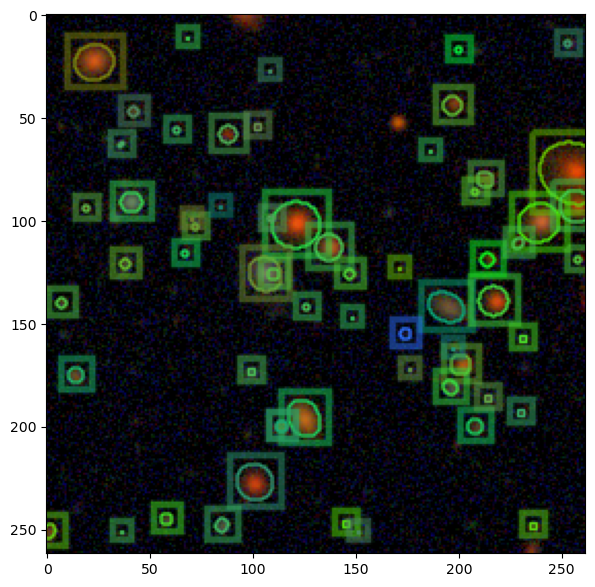

In [12]:
from deepdisc.astrodet.visualizer import ColorMode
from deepdisc.astrodet.visualizer import Visualizer
from astropy.visualization import make_lupton_rgb
import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))

# img_cutout_data = np.load('./lsst_data/truth/3828/1,1/full_c1.npy')
image = datsm
# b1 = img_cutout_data[2]
# b2 = img_cutout_data[1]
# b3 = img_cutout_data[0]
stretch=0.5
Q = 10
img = make_lupton_rgb(b1, b2, b3, minimum=0, stretch=stretch, Q=Q)

print("total instances:", len(ddict["annotations"]))
v0 = Visualizer(
    img,
    metadata=astrotest_metadata,
    scale=1,
    instance_mode=ColorMode.SEGMENTATION,  # remove the colors of unsegmented pixels. This option is only available for segmentation models
)

groundTruth = v0.draw_dataset_dict(ddict, lf=False, alpha=0.1, boxf=True)

ax1 = plt.subplot(1, 1, 1)
ax1.imshow(groundTruth.get_image())
#ax1.axis("off")

#ax1.scatter(dcutr[(dcutr['new_x']>400) & (dcutr['new_y']>100)].new_x.values-400,dcutr[(dcutr['new_x']>400) & (dcutr['new_y']>100)].new_y.values-100,s=5,color='w')
#ax1.set_ylim(0,100)

In [13]:
print(np.unique([ann['category_id'] for ann in ddict['annotations']]))
instances = np.asarray([ann['category_id'] for ann in ddict['annotations']])
count_zeros = np.count_nonzero(instances == 0)
print("Number of Galaxies: ", count_zeros)
print("Number of Stars: ", len(instances) - count_zeros)

[0 1]
Number of Galaxies:  60
Number of Stars:  1


In [64]:
np.save(f'./lsst_data/truth/{tract}_{patch}/full_c{sp}_{tract}_{patch}.npy', datsm)

In [66]:
dcutr.to_json(f'./lsst_data/truth/{tract}_{patch}/c{sp}_{tract}_{patch}.json', orient='records')

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(ra_patch,dec_patch, s=1, label='Whole Patch')
plt.scatter(dcutr['ra'], dcutr['dec'], s=1, label='Sub Patch')
plt.legend()
plt.xlabel('RA')
plt.ylabel('Dec')

## Visualizing Masks from NERSC LSST Overlapping Data

total instances: 27


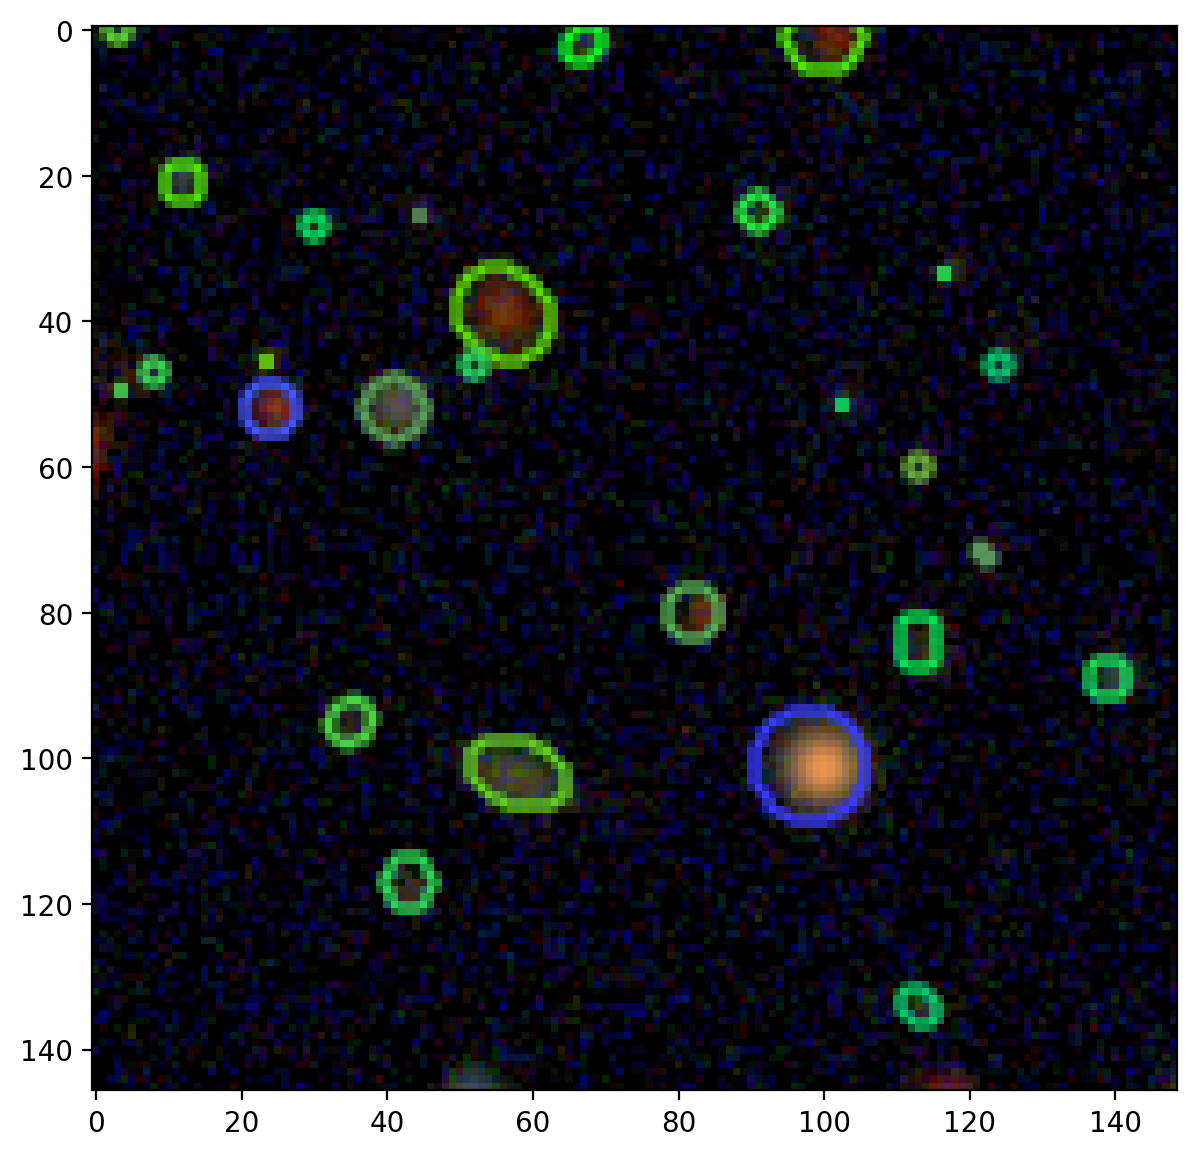

In [27]:
from deepdisc.astrodet.visualizer import ColorMode
from deepdisc.astrodet.visualizer import Visualizer
from astropy.visualization import make_lupton_rgb
import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))

# from Using Overlapping LSST Data pulled from NERSC section
img = np.load(d1['file_name'])
img = np.transpose(img, axes=(1,2,0)).astype(np.float32) # to get (height, width, channels)
b1 = img[:, :, 2]
b2 = img[:, :, 1]
b3 = img[:, :, 0]
stretch=0.5
Q = 10
img = make_lupton_rgb(b1, b2, b3, minimum=0, stretch=stretch, Q=Q)
print("total instances:", len(d1["annotations"]))
v0 = Visualizer(
    img,
    metadata=astrotest_metadata,
    scale=1,
    instance_mode=ColorMode.SEGMENTATION,  # remove the colors of unsegmented pixels. This option is only available for segmentation models
)

groundTruth = v0.draw_dataset_dict(d1, lf=False, alpha=0.1, boxf=False)# boxf turns off bounding box

ax1 = plt.subplot(1, 1, 1)
ax1.imshow(groundTruth.get_image())
#ax1.axis("off")

## New Sims

In [17]:
dpatch_new = pd.read_csv('/home/yse2/10053_galaxy_cat.csv')

ra_patch_n = dpatch_new['ra_true'][:].values
dec_patch_n = dpatch_new['dec_true'][:].values
patchcatalog_n = SkyCoord(ra=ra_patch*u.degree, dec=dec_patch*u.degree)

In [ ]:
#datsm2,dcut2,psf2 = get_cutout_cat(dirpath, dpatch_btk, patchcatalog_btk, 'galaxy_id', '3828','1,2',29,nblocks=16)
#datsm2,dcut2,psf2 = get_cutout_cat(dirpath, dpatch_btk, patchcatalog_btk, 'galaxy_id', '3828','1,2',29,nblocks=16)
# datsm,dcut,psf = get_cutout_cat(dirpath, dpatch, patchcatalog, 'galaxy_id', '3828','1,2',22,nblocks=8)
# def get_cutout_cat(dirpath,dcat,skycoords, id_col, tract,patch,sp,nblocks=4,filters=['u','g','r','i','z','y']):
#     '''
#         WARNING!!!!!
#         It is not efficient to have the full catalog (defined here as dall) as input to a function when doing multiprocesing.  
#         Keep it in the top level process
#     '''
#     # the below should work properly
#     cutout,datsm, psf = get_cutout(dirpath,tract=tract,patch=patch,sp=sp,nblocks=nblocks,filters=filters,plot=False, get_psf=True)
#     xs,ys = cutout.wcs.world_to_pixel(skycoords)

#     inds = np.where((xs>=0) & (xs<cutout.shape[1]-1) & (ys>=0) & (ys<cutout.shape[0]-1))[0]
    
 
#     dcut = dcat.iloc[inds]

#     dcut['new_x'] = xs[inds]
#     dcut['new_y'] = ys[inds]
    
#     return datsm, dcut#, psf

datsm_n, dcut_n = get_cutout_cat(dirpath, dpatch, patchcatalog, 'galaxy_id', '2877','1,2', sp, nblocks=nb)
dcutr = dcut_reformat(dcut, only_bttri=True)
survey = btk.survey.get_surveys("LSST")
filt = 'i'
ddict = create_metadata(datsm,dcutr, survey,filt,lvl=3)

In [21]:
survey = btk.survey.get_surveys("LSST")
filt = 'i'
psf = survey.get_filter(filt).psf
sky_level = mean_sky_level(survey, filt).to_value('electron') # gain = 1

In [23]:
dpatch_new.iloc[5]

Unnamed: 0                       5.000000e+00
mag_u                            2.487243e+01
galaxy_id                        1.005300e+13
mag_i                            2.439323e+01
mag_y                            2.390015e+01
bulge_to_total_ratio             7.176412e-01
shear1                           0.000000e+00
ellipticity_disk_true            2.774103e-01
redshift                         9.812257e-01
dec_true                        -4.049415e+01
diskEllipticity1                -2.717367e-01
um_source_galaxy_obs_sm          1.222546e+09
diskHalfLightRadiusArcsec        1.933512e-01
mag_r                            2.482425e+01
size_disk_true                   1.933512e-01
spheroidHalfLightRadiusArcsec    9.810912e-02
ellipticity_bulge_true           6.429475e-02
mag_g                            2.491675e+01
ellipticity_true                 1.244698e-01
spheroidEllipticity2             1.293677e-02
ra_true                          1.448678e+01
shear2                           0

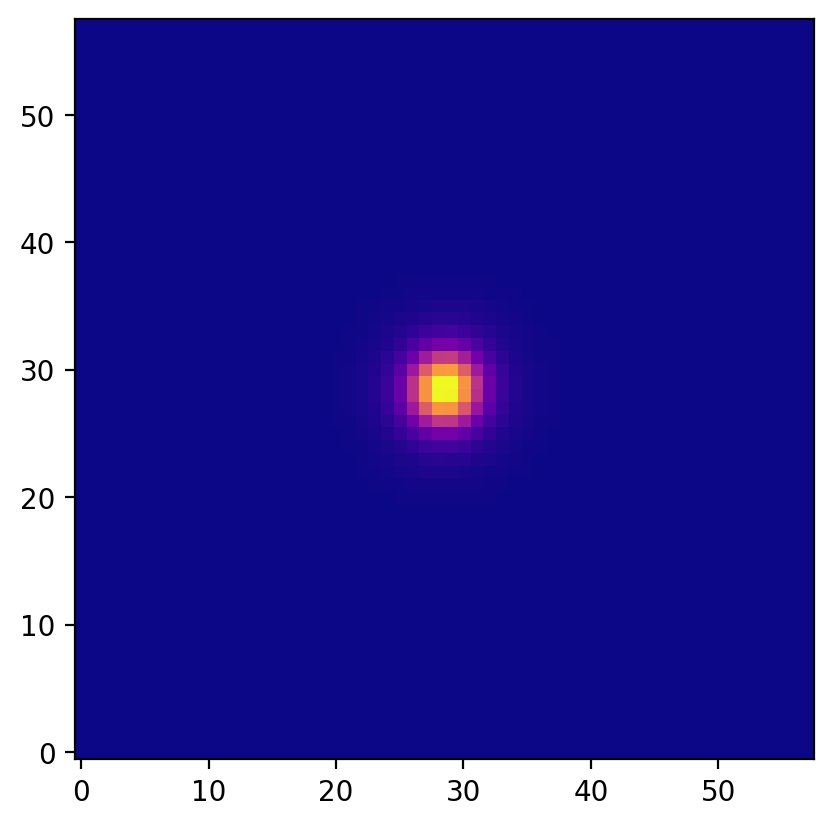

In [29]:
from galcheat.utilities import mag2counts, mean_sky_level
from btk.survey import Filter, Survey, make_wcs
import galsim
import btk
import logging

seed = 8312
rng = np.random.RandomState(seed)
grng = galsim.BaseDeviate(rng.randint(0, 2**30))
logger = logging.getLogger(__name__)

# from https://github.com/LSSTDESC/skyCatalogs/blob/main/skycatalogs/objects/diffsky_object.py
def get_knot_n(entry, i, seed=None):
    """
    Return random value for number of knots based on galaxy sm.
    """
    rng = np.random.default_rng(seed)
    ud = rng.uniform()

    um_source_galaxy_obs_sm = entry["um_source_galaxy_obs_sm"][i]

    sm = np.log10(um_source_galaxy_obs_sm)
    m = (50 - 3) / (12 - 6)  # (knot_n range)/(logsm range)
    n_knot_max = m * (sm - 6) + 3
    n_knot = int(ud * n_knot_max)  # random n up to n_knot_max

    logger.info(f"simulating {n_knot} knots for galaxy {i}")

    return n_knot

def get_morphology(entry, n_knots=0):
    components = []
    _start_time = time.time()
    
    bulge_ellipticity = galsim.Shear(
        g1=entry["spheroidEllipticity1"], # test if these ellipticities are accurate w/o pa
        g2=entry["spheroidEllipticity2"],
    )
    bulge = galsim.DeVaucouleurs(
        half_light_radius=entry["spheroidHalfLightRadiusArcsec"],
    ).shear(bulge_ellipticity)
    
    disk_ellipticity = galsim.Shear(
        g1=entry["diskEllipticity1"],
        g2=entry["diskEllipticity2"],
    )
    disk = galsim.Exponential(
        half_light_radius=entry["diskHalfLightRadiusArcsec"],
    ).shear(disk_ellipticity)
#         disk = galsim.Exponential(flux=disk_flux, half_light_radius=disk_hlr_arcsecs).shear(
#             e1=-e1_disk, e2=e2_disk
#         )
    if n_knots > 0:
        knots = galsim.RandomKnots(
            n_knots,
            profile=disk,
        )
    else:
        knots = None

    _end_time = time.time()
    _elapsed_time = _end_time - _start_time
    logger.debug(f"made galaxy morphology in {_elapsed_time} seconds")
    
    components.append(bulge)
    components.append(disk)
    components.append(knots)
    
    profile = galsim.Add(components)
#     return bulge, disk, knots
    return profile
# tract 2877, patch 19
n_knots = get_knot_n(dpatch_new, 5)
morph = get_morphology(dpatch_new.iloc[5], n_knots=n_knots)
observed = galsim.Convolve([psf, morph])
image = observed.drawImage(scale=survey.pixel_scale.to_value("arcsec"))
plt.imshow(image.array, cmap='plasma', origin="lower")

# i = 0

# params = roman_rubin.get_morphology_params(i)
# morph = diffsky.get_morphology(*params)

# psf = galsim.Gaussian(fwhm=0.7)
# observed = galsim.Convolve([psf, morph])
# image = observed.drawImage(scale=0.2)

# axs.imshow(image.array, origin="lower")


# def make_galaxy(entry, survey, filt, no_disk= False, no_bulge = False, no_agn = True):
#     components = []
#     total_flux = mag2counts(entry[filt.name + "_ab"], survey, filt).to_value("electron")
#     # Calculate the flux of each component in detected electrons.
#     total_fluxnorm = entry["fluxnorm_disk_"+filt.name] + entry["fluxnorm_bulge_"+filt.name] + entry["fluxnorm_agn_"+filt.name]
#     disk_flux = 0.0 if no_disk else entry["fluxnorm_disk_"+filt.name] / total_fluxnorm * total_flux
#     bulge_flux = 0.0 if no_bulge else entry["fluxnorm_bulge_"+filt.name] / total_fluxnorm * total_flux
#     agn_flux = 0.0 if no_agn else entry["fluxnorm_agn_"+filt.name] / total_fluxnorm * total_flux

#     if disk_flux + bulge_flux + agn_flux == 0:
#         raise SourceNotVisible

#     if disk_flux > 0:
#         a_d, b_d = entry["a_d"], entry["b_d"]
#         disk_hlr_arcsecs=entry['size_disk_true']
        
        
#         disk_q = entry['size_minor_disk_true']/entry['size_disk_true']
#         pa = np.pi*entry['position_angle_true_dc2']/180
        
#         epsilon_disk = (1 - disk_q) / (1 + disk_q)
        
#         e1_disk = epsilon_disk * np.cos(2 * pa)
#         e2_disk = epsilon_disk * np.sin(2 * pa)

#         disk = galsim.Exponential(flux=disk_flux, half_light_radius=disk_hlr_arcsecs).shear(
#             e1=-e1_disk, e2=e2_disk
#         )
        
#         components.append(disk)
        
        
#     if bulge_flux > 0:
#         a_b, b_b = entry["a_b"], entry["b_b"]
#         bulge_hlr_arcsecs = np.sqrt(a_b * b_b)

#         bulge_q = entry['size_minor_bulge_true']/entry['size_bulge_true']

#         pa = np.pi*entry['position_angle_true_dc2']/180

        
#         epsilon_bulge = (1 - bulge_q) / (1 + bulge_q)
        
#         e1_bulge = epsilon_bulge * np.cos(2 * pa)
#         e2_bulge = epsilon_bulge * np.sin(2 * pa)
        
#         bulge = galsim.DeVaucouleurs(flux=bulge_flux, half_light_radius=bulge_hlr_arcsecs).shear(
#            e1=-e1_bulge, e2=e2_bulge
#         )
#         components.append(bulge)

#     if agn_flux > 0:
#         agn = galsim.Gaussian(flux=agn_flux, sigma=1e-8)
#         components.append(agn)

#     profile = galsim.Add(components)
#     return profile

# def make_seg(entry, survey, filt, lvl, nx=128, ny=128):
#     psf = survey.get_filter(filt).psf
#     sky_level = mean_sky_level(survey, filt).to_value('electron') # gain = 1
#     obj_type = entry['truth_type'] # 1 for galaxies, 2 for stars
#     im = None
#     mag = None
#     if obj_type == 1:
#         gal = make_galaxy(entry, survey, survey.get_filter(filt))
#         gal = gal.shear(g1=entry["g1"], g2=entry["g2"])
#         conv_gal = galsim.Convolve(gal, psf)
#         im = conv_gal.drawImage(
#             nx=nx,
#             ny=ny,
#             scale=survey.pixel_scale.to_value("arcsec")
#         )
#     else:
#         star, gsparams, mag = make_star(entry, survey, survey.get_filter(filt))
#         max_n_photons = 10_000_000
#         flux = mag2counts(mag,survey,filt).to_value("electron")
#         # 0 means use the flux for n_photons 
#         n_photons = 0 if flux < max_n_photons else max_n_photons
#         # n_photons = 0 if entry[f'flux_{filt}'] < max_n_photons else max_n_photons
#         conv_star = galsim.Convolve(star, psf)
#         im = conv_star.drawImage(
#             nx=nx,
#             ny=ny,
#             scale=survey.pixel_scale.to_value("arcsec"),
#             method="phot",
#             n_photons=n_photons,
#             poisson_flux=True,
#             maxN=1_000_000,  # shoot in batches this size
#             rng=grng
#         )
#     imd = np.expand_dims(np.expand_dims(im.array,0),0)
#     # thresh for mask set relative to the bg noise level which is what sigma_noise is
#     # so lower the thresh for the star to include more of its light
#     # so lower sigma_noise, bigger masks and higher lvl, smaller masks bc it'll only capture very brightest central part of star
# #     if obj_type == 2: # if star, 
# #         segs = btk.metrics.utils.get_segmentation(imd, sky_level, sigma_noise=lvl * 0.02)
# #     else:
# #         segs = btk.metrics.utils.get_segmentation(imd, sky_level, sigma_noise=lvl) 
#     segs = btk.metrics.utils.get_segmentation(imd, sky_level, sigma_noise=lvl) 
#     return segs[0][0], mag

# def get_bbox(mask):
#     rows = np.any(mask, axis=1)
#     cols = np.any(mask, axis=0)
#     rmin, rmax = np.where(rows)[0][[0, -1]]
#     cmin, cmax = np.where(cols)[0][[0, -1]]

#     return rmin-4, rmax+4, cmin-4, cmax+4

In [ ]:
import os
import json
import numpy as np
from multiprocessing import Pool
from functools import partial

def combine_images(entry, lsst_dir, roman_dir, output_dir):
    lsst_file = entry['file_name']
    roman_file = lsst_file.replace('truth-lsst', 'truth')
    output_file = lsst_file.replace('truth-lsst', 'truth-combined')

    # Ensure output directory exists
    os.makedirs(os.path.dirname(output_file), exist_ok=True)

    # Load LSST and Roman images
    lsst_img = np.load(lsst_file)
    roman_img = np.load(roman_file)

    # Combine images
    combined_img = np.concatenate((roman_img, lsst_img), axis=0)

    # Save combined image
    np.save(output_file, combined_img)

    return f"Combined and saved: {output_file}"

def process_subpatch(subpatch, lsst_dir, roman_dir, output_dir):
    annotation_file = os.path.join(lsst_dir, f'{subpatch}.json')
    
    with open(annotation_file, 'r') as f:
        annotations = json.load(f)

    combine_func = partial(combine_images, lsst_dir=lsst_dir, roman_dir=roman_dir, output_dir=output_dir)

    with Pool() as pool:
        results = pool.map(combine_func, annotations)

    return results

def main():
    lsst_dir = '/path/to/lsst/data'
    roman_dir = '/path/to/roman/data'
    output_dir = '/path/to/output/combined/data'
    
    sub_patches = ['dc2_50.93_-42.0', 'dc2_51.34_-41.3', 'dc2_51.53_-40.0', 
                   'dc2_52.31_-41.6', 'dc2_52.93_-40.8', 'dc2_51.37_-38.3',
                   'dc2_53.25_-41.8', 'dc2_53.75_-38.9', 'dc2_54.24_-38.3',
                   'dc2_54.31_-41.6', 'dc2_55.03_-41.9', 'dc2_56.06_-39.8']

    for subpatch in sub_patches:
        print(f"Processing subpatch: {subpatch}")
        results = process_subpatch(subpatch, lsst_dir, roman_dir, output_dir)
        for result in results:
            print(result)

if __name__ == "__main__":
    main()

# IGNORE

In [21]:
import os
import json
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy import units as u
from io import StringIO  

def process_roman_folders(base_path):
    roman_data = []
    for folder in os.listdir(base_path):
        if folder.startswith('dc2_'):
            folder_path = os.path.join(base_path, folder)
            json_path = os.path.join(folder_path, f'{folder_path[-15:]}_info_all.json')
            if os.path.exists(json_path):
                with open(json_path, 'r') as f:
                    data = json.load(f)
                for entry in data:
                    objects_info = pd.read_json(StringIO(entry['objects_info']))
                    objects_info['folder'] = folder
                    roman_data.append(objects_info[['ra', 'dec', 'folder']])
    return pd.concat(roman_data).drop_duplicates()

def process_lsst_folders(base_path):
    lsst_data = []
    for folder in os.listdir(base_path):
        if ',' in folder:
            folder_path = os.path.join(base_path, folder)
            json_path = os.path.join(folder_path, f'{folder}_info.json')
            if os.path.exists(json_path):
                with open(json_path, 'r') as f:
                    data = json.load(f)
                for entry in data:
                    objects_info = pd.read_json(StringIO(entry['obj_catalog']))
                    objects_info['folder'] = folder
                    lsst_data.append(objects_info[['ra', 'dec', 'folder']])
    return pd.concat(lsst_data)

# Main execution
roman_base_path = './roman_data/truth'
lsst_base_path = './lsst_data/truth/3828'

roman_df = process_roman_folders(roman_base_path)
lsst_df = process_lsst_folders(lsst_base_path)
# Save results
# roman_df.to_csv('roman_catalog.csv', index=False)
# lsst_df.to_csv('lsst_catalog.csv', index=False)
# cross_matched.to_csv('cross_matched_catalog.csv', index=False)



In [22]:
print(f"Processed {len(roman_df)} Roman objects and {len(lsst_df)} LSST objects.")

Processed 158061 Roman objects and 218001 LSST objects.


In [35]:
print(min(lsst_df['ra']), min(lsst_df['dec']))

56.7807137744 -37.0071473309


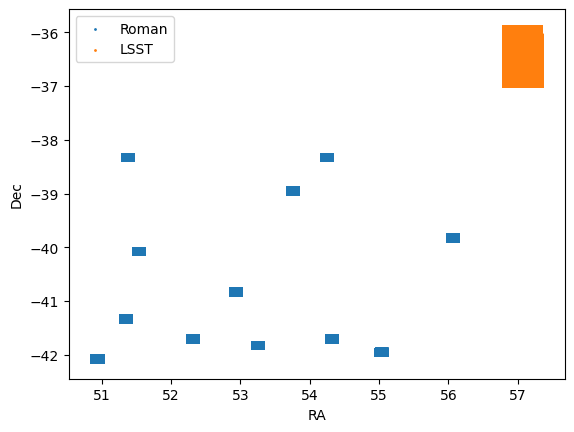

In [33]:
import matplotlib.pyplot as plt
plt.scatter(roman_df['ra'], roman_df['dec'], s=1, label='Roman')
plt.scatter(lsst_df['ra'], lsst_df['dec'], s=1, label='LSST')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.legend()

In [40]:
# Setting up imports
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.table import Table
from astropy import wcs
from astropy.coordinates import SkyCoord

import cv2
import glob
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import astropy.units as u

# det_files = ['roman_data/detection_fits/dc2_det_56.03_-38.5.fits.gz']
# det = fits.open(det_file)
# det_df = Table.read(det,hdu=1).to_pandas()
truth_all_df = pd.DataFrame()
truth_files = ['roman_data/truth_fits/dc2_index_56.03_-38.5.fits.gz']
for truth_file in truth_files:
    truth = fits.open(truth_file)
    truth_df = Table.read(truth,hdu=1).to_pandas()
    pd.concat([truth_df, truth_all_df], ignore_index=True)


,ind,sca,dither,x,y,ra,dec,mag_Y106,mag_J129,mag_H158,mag_F184,stamp,start_row,gal_star,dered_Y106,dered_J129,dered_H158,dered_F184
0,5037,11,133808,2499.140495,6824.483101,56.068172,-38.531105,25.194095,25.290795,25.433946,25.643570,0,0,1,-0.037545,-0.027437,-0.020008,-0.015435
1,16736,10,133808,6408.783193,4641.743853,55.988326,-38.565967,17.979178,17.646667,17.565549,17.558204,512,0,1,-0.058523,-0.042506,-0.030880,-0.023907
2,16738,10,133808,7704.326151,4188.521504,55.961855,-38.573194,20.568320,20.405379,20.374778,20.484386,512,0,1,-0.020131,-0.013543,-0.009414,-0.006922
3,23547,11,133808,2182.169382,8193.472039,56.074630,-38.509237,20.491626,20.329118,20.286134,20.392913,512,0,1,-0.115956,-0.083967,-0.061138,-0.047436
4,23579,11,133808,1815.427918,7740.301176,56.082122,-38.516472,17.377425,17.214918,17.171933,17.278713,512,0,1,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34972,69544642,10,133808,6111.893650,2619.620666,55.994376,-38.598267,30.068641,30.247513,30.155718,30.113882,0,0,0,0.000000,0.000000,0.000000,0.000000
34973,69544647,10,133808,6210.611164,3052.670792,55.992362,-38.591350,28.976664,29.071500,28.857269,29.971980,0,0,0,-0.121599,-0.106717,-0.089142,0.000000
34974,69544704,10,133808,5006.949101,7698.322833,56.016971,-38.517154,28.650527,28.774352,28.630776,28.564405,0,0,0,0.000000,0.000000,0.000000,0.000000
34975,69544914,10,133808,5214.856550,3891.167522,56.012713,-38.577962,28.528601,28.652054,28.443429,28.415845,0,0,0,0.000000,0.000000,0.000000,0.000000


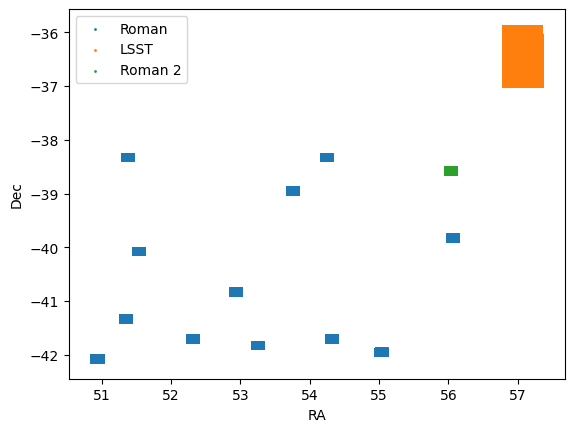

In [41]:
plt.scatter(roman_df['ra'], roman_df['dec'], s=1, label='Roman')
plt.scatter(lsst_df['ra'], lsst_df['dec'], s=1, label='LSST')
plt.scatter(truth_df['ra'], truth_df['dec'], s=1, label='Roman 2')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.legend()

In [26]:
def cross_match_catalogs(roman_df, lsst_df, max_separation=1.0):
    roman_coords = SkyCoord(ra=(roman_df['ra'].values)*u.degree, dec=(roman_df['dec'].values)*u.degree)
    lsst_coords = SkyCoord(ra=(lsst_df['ra'].values)*u.degree, dec=(lsst_df['dec'].values)*u.degree)
    
    max_sep = max_separation * u.arcsec
    idx, d2d, _ = roman_coords.match_to_catalog_sky(lsst_coords)
    matches = d2d < max_sep
    
    result = pd.DataFrame({
        'roman_ra': roman_df['ra'][matches],
        'roman_dec': roman_df['dec'][matches],
        'roman_folder': roman_df['folder'][matches],
        'lsst_ra': lsst_df['ra'][idx[matches]],
        'lsst_dec': lsst_df['dec'][idx[matches]],
        'lsst_patch': lsst_df['folder'][idx[matches]],
        'separation': d2d[matches].arcsec
    })
    
    return result
cross_matched = cross_match_catalogs(roman_df, lsst_df)

In [27]:
print(f"Found {len(cross_matched)} cross-matched objects.")

Found 0 cross-matched objects.


In [ ]:
from deepdisc.preprocessing.get_data import get_cutout
filters = ['u','g','r','i','z','y']
#dirpath = '/home/g4merz/DC2/coadd-t3828-t3829/deepCoadd-results/'
dirpath = '/home/shared/hsc/DC2/raw_data/dr6/'
nb=16 #The number of cutouts per side of an image.  4k CCDs are too large to train with, so we reduce the size
sp=18 #The "subpatch", i.e. which of the nb x nb cutouts to use 

In [ ]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.stats import gaussian_fwhm_to_sigma

dall=pd.read_csv('/home/shared/hsc/DC2/raw_data/all_tracts_truth_cat.csv')
#dall=pd.read_csv('/home/g4merz/DC2/nersc_data/data/tracts_data/all_tracts_cat.csv')

ra_all = dall['ra'][:].values
dec_all = dall['dec'][:].values
allcatalog = SkyCoord(ra=ra_all*u.degree, dec=dec_all*u.degree)

dpatch=pd.read_csv('/home/shared/hsc/DC2/raw_data/3828_1,2_truthcat.csv')
#dall=pd.read_csv('/home/g4merz/DC2/nersc_data/data/tracts_data/all_tracts_cat.csv')

ra_patch = dpatch['ra'][:].values
dec_patch = dpatch['dec'][:].values
patchcatalog = SkyCoord(ra=ra_patch*u.degree, dec=dec_patch*u.degree)

In [ ]:
mag = 18.5422
flux = L0 * 10**(-0.4 * mag)

star = galsim.Gaussian(
#     fwhm=1.0e-4,
    half_light_radius=2.2925904712098424,
    flux=flux,
)


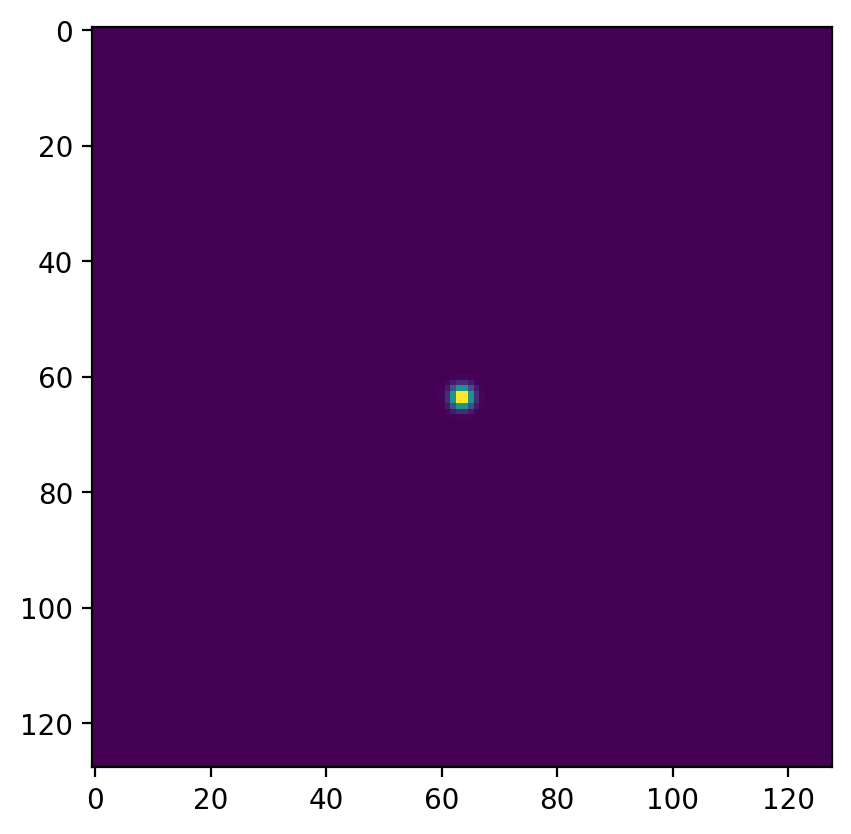

In [39]:
plt.imshow(star.drawImage(nx=128, ny=128).array)

In [41]:
df = pd.read_json('roman_data/truth/dc2_50.93_-42.0/dc2_50.93_-42.0_info_all.json', orient='records')

In [90]:
entry = df.iloc[2]
file = entry['file_name']
img = np.load(file)[0, :, :]
objs = pd.read_json(entry['objects_info'], orient='records')
# plt.axis('off')
# plt.scatter(dcut.new_x.values,dcut.new_y.values,s=1)

/tmp/ipykernel_1165372/1093784206.py:4: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  objs = pd.read_json(entry['objects_info'], orient='records')


In [97]:
ras = objs['ra'].values
decs = objs['dec'].values
cat = SkyCoord(ra=ras*u.degree, dec=decs*u.degree)
wcs = WCS(entry['wcs'])
xs, ys = wcs.world_to_pixel(cat)

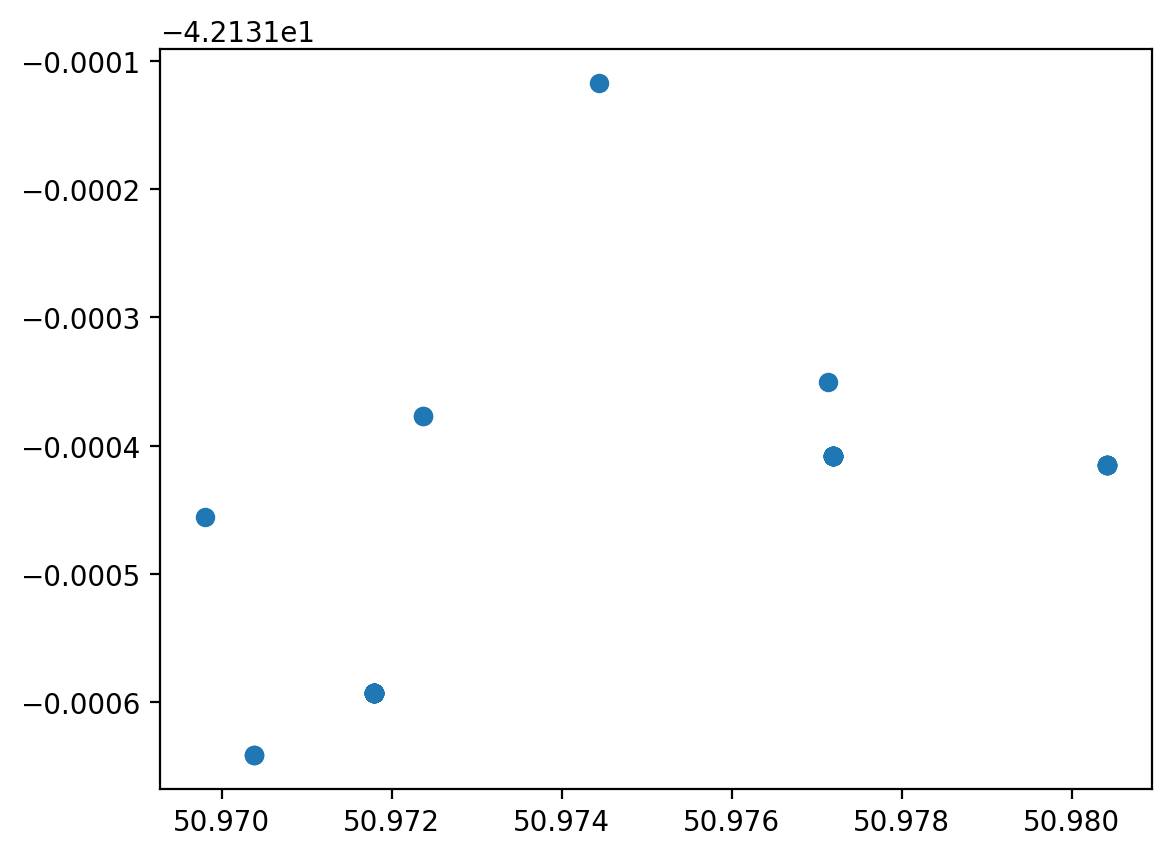

In [106]:
# plt.xlim(50.976, 51)
plt.scatter(ras,decs)

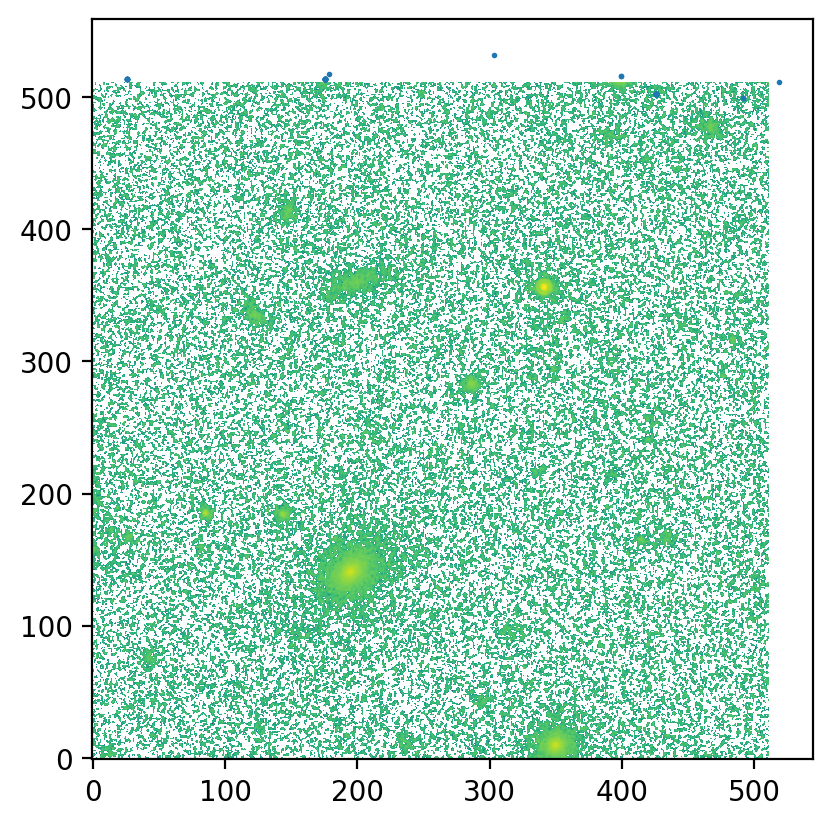

In [92]:
plt.imshow(img, norm=colors.LogNorm(), origin='lower')
# xs,ys = cutout.wcs.world_to_pixel(skycoords)
plt.scatter(xs,ys, s=1)

In [47]:
entry

image_id                                                        2
file_name       ./roman_data/truth/dc2_50.93_-42.0/full_c2_50....
wcs             WCSAXES =                    2 / Number of coo...
objects_info    [{"ind":46124835,"sca":1,"dither":133533,"x":1...
Name: 0, dtype: object